# references:
https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/

In [2]:
# import required libraries
#!conda install nltk
import numpy as np
import pandas as pd
import nltk
import re
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context
#nltk.download('punkt')

In [3]:
with open('pride_and_prejudice.txt','r') as f:
#with open('Pride and Prejudice.txt','r') as f:
    full_txt = f.read().strip('\n').replace("\''","'")
    # clean the unnecessary txt
    full_txt = full_txt.replace('_','').replace('make by 拉米网（www.lami.fun）','') 

In [4]:
#!pip install wordcloud

Populating the interactive namespace from numpy and matplotlib


(-0.5, 399.5, 199.5, -0.5)

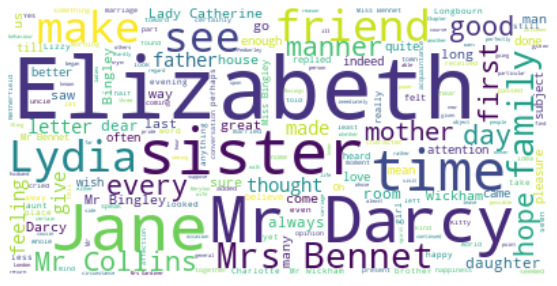

In [160]:
from wordcloud import WordCloud,STOPWORDS
sw = list(STOPWORDS)  + [
    "will","must","said","much","well", "one", "now", 'though','say','two','think','think',
    'know','soon','might','without','never','may','little','nothing'
]

wordcloud = WordCloud(background_color = 'white',stopwords=sw).generate(full_txt)
%pylab inline
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Partition (chapters/paragraphs/sentences)

In [6]:
# chapter-wise
chapter_txt = full_txt.split('Chapter ')[1:] #len(chapter_txt)=61
cleaned_chapter = []
for chapter in chapter_txt:
    cleaned_chapter.append(chapter[1:].replace('\n',''))
len(cleaned_chapter)

61

In [7]:
# paragraph-wise
cleaned_paragraph = []
for chapter in chapter_txt:
    para = [i for i in chapter.split('\n') if i != ""]
    cleaned_paragraph = cleaned_paragraph + para[1:]
len(cleaned_paragraph)

2063

In [8]:
# sentence-wise
cleaned_sentence = []
from nltk.tokenize import sent_tokenize
cleaned_sentence = [sent_tokenize(chapter) for chapter in cleaned_chapter]
cleaned_sentence = [x for y in cleaned_sentence for x in y]
len(cleaned_sentence)

5584

In [9]:
from nltk.tokenize import sent_tokenize
total_sentences = [sent_tokenize(chapter) for chapter in cleaned_chapter]
#cleaned_sentence = [x for y in cleaned_sentence for x in y]
sentencesPerChap = [len(sentences) for sentences in total_sentences]
split_point = [0]
for i in range(len(total_sentences)):
    split_point.append(split_point[i]+sentencesPerChap[i])

In [199]:
CHARACTER_LIST = [
    'Mr. Darcy', 'Mr. Bingley','Elizabeth','Miss Bingley','Lydia','Lady Catherine', # 0 ~ 5
    'Mary','Georgiana','Collins','Charlotte','Mr. Wickham',         #6 ~ 10
    'Miss de Bourgh','Mr. Bennet','Mrs. Bennet','Jane','Louisa',    #11 ~ 15
    'Mr. Hurst','Lucases','Miss Lucas','Sir William','Mrs. Gardiner',  # 16 ~20
    'Mr. Gardiner','Mr. Phillips','Mrs. Phillips','Fitzwilliam','Colonel Forster', #21~25
    'Mrs. Forster','Mr. Jones', #26～28
]

NICKNAME_LIST = [
    'Lizzy','Miss Lucas','Caroline','Miss Darcy','Lady Lucas','Mrs. Hurst','Charles','Darcy','Bingley'
]

MATCH = [(2,0),(9,1),(3,2),(6,3),(8,4),(14,5),(1,6),(0,7),(1,8)]
                                        
num_people = len(CHARACTER_LIST)                                    

In [239]:
def name_plus_nick(list_1,list_2):
    co_list = []
    len_1 = len(list_1)
    for i in range(len_1):
        if list_1[i]+list_2[i] == 0:
            co_list.append(0)
        else:
            co_list.append(1)
    return co_list

In [240]:
def find_interaction(sections, consider_sentiment = False):
    Characters = {}
    occurrence = []
    occurrence_2 = []
    for person in CHARACTER_LIST:
        vector = []
        for section in sections:
            if person in section:
                vector.append(1)
            else:
                vector.append(0)
        occurrence.append(np.array(vector))
        Characters[person] = np.array(vector)
    
    for person in NICKNAME_LIST:
        vector = []
        for section in sections:
            if person in section:
                vector.append(1)
            else:
                vector.append(0)
        occurrence_2.append(np.array(vector))
    
    for match in MATCH:
        name = match[0]
        nick = match[1]
        occur_new = name_plus_nick(occurrence[name],occurrence_2[nick])
        occurrence[name] = occur_new
        person = CHARACTER_LIST[name]
        Characters[person] = occur_new

    occurrence_matrix = pd.DataFrame(occurrence)
        
    if not consider_sentiment:
        co_occur = pd.DataFrame(np.dot(occurrence_matrix,occurrence_matrix.T))
        np.fill_diagonal(co_occur.values, 0) # remove the self
        co_occur = co_occur / co_occur.sum(axis = 0)
    else:
        sentiments = []
        for section in sections:
            sentence_list = nltk.tokenize.sent_tokenize(section)
            sentiments_2 = 0
            for sentence in sentence_list:
                vs = analyzer.polarity_scores(sentence)
                sentiments_2 += vs['compound']
            sentiments.append(sentiments_2/len(sentence_list))

        sentiment_matrix =np.dot(occurrence_matrix, (occurrence_matrix.T * np.array(sentiments).reshape(-1,1)))
        sentiment_matrix = pd.DataFrame(sentiment_matrix)
        np.fill_diagonal(sentiment_matrix.values, 0) # remove the self
        
        sentiment_matrix = (sentiment_matrix - sentiment_matrix.min(axis=0)) / (sentiment_matrix.max(axis=0) - sentiment_matrix.min(axis=0))
        sentiment_matrix = sentiment_matrix / sentiment_matrix.sum(axis = 0)
        co_occur = sentiment_matrix
        
        print(sentiment_matrix.shape)
    
    return co_occur, occurrence_matrix, Characters

In [262]:
def text_rank(section_name, section, consider_sentiment = False, alpha = 0.85):
    co_occur, occurrence, Characters = find_interaction(section, consider_sentiment)
    P = co_occur
    P = alpha* co_occur + (1-alpha)*np.ones((num_people,num_people))/num_people
    # interation PageRank
    rank_inter = np.ones((num_people, 1))/num_people
    for i in range(10000):
        rank_inter = np.dot(P,rank_inter)
    rank_inter = rank_inter.reshape(-1,)
    text_rank = rank_inter[np.argsort(rank_inter)[::-1]].tolist()
    text_chara = [CHARACTER_LIST[i] for i in np.argsort(rank_inter)[::-1].tolist()]
    Characters_sort = sorted(Characters.items(), key=lambda x: sum(x[1]), reverse = True)
    occur_rank = [sum(character[1]) for character in Characters_sort]
    occur_chara = [character[0] for character in Characters_sort]
  
    rank_table = pd.DataFrame([text_chara, occur_chara]).T
    rank_table.columns = ['TextRank','Occurrence Rank']
    rank_table.index = np.arange(1,num_people+1).tolist()
    print(rank_table)
    
    x = np.arange(len(CHARACTER_LIST)).tolist()
    plt.figure(figsize=(15,5))
    plt.bar(x, text_rank)
    plt.xticks(x, text_chara, rotation=45)
    if not consider_sentiment:
        plt.title(f'PageRank by {section_name} (Only Co-occurrence)')
    else:
        plt.title(f'PageRank by {section_name} (with Sentiments)')
    
    plt.show()
    return occurrence, P

           TextRank  Occurrence Rank
1         Elizabeth        Elizabeth
2              Jane             Jane
3         Mr. Darcy        Mr. Darcy
4       Mr. Bingley      Mr. Bingley
5       Mrs. Bennet      Mrs. Bennet
6           Collins          Collins
7              Mary             Mary
8             Lydia            Lydia
9      Miss Bingley        Charlotte
10        Charlotte     Miss Bingley
11       Mr. Bennet   Lady Catherine
12   Lady Catherine       Mr. Bennet
13      Mr. Wickham      Mr. Wickham
14      Sir William      Sir William
15    Mrs. Gardiner    Mrs. Gardiner
16       Miss Lucas   Miss de Bourgh
17   Miss de Bourgh     Mr. Gardiner
18     Mr. Gardiner          Lucases
19  Colonel Forster       Miss Lucas
20          Lucases  Colonel Forster
21    Mrs. Phillips      Fitzwilliam
22      Fitzwilliam        Georgiana
23        Georgiana    Mrs. Phillips
24        Mr. Hurst        Mr. Hurst
25           Louisa           Louisa
26     Mrs. Forster     Mrs. Forster
2

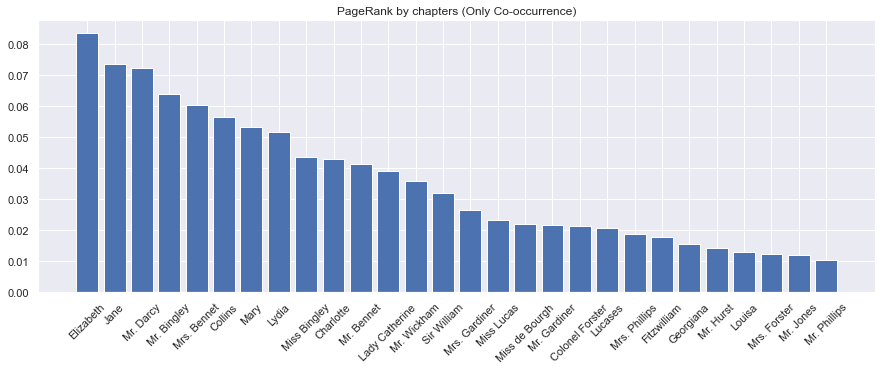

,Source,Target,Weight
0,Mr. Darcy,Mr. Darcy,0.00535714
1,Mr. Darcy,Mr. Bingley,0.0865027
2,Mr. Darcy,Elizabeth,0.081522
3,Mr. Darcy,Miss Bingley,0.083196
4,Mr. Darcy,Lydia,0.0715248
...,...,...,...
779,Mr. Jones,Mrs. Phillips,0.0232519
780,Mr. Jones,Fitzwilliam,0.00535714
781,Mr. Jones,Colonel Forster,0.0202694
782,Mr. Jones,Mrs. Forster,0.00535714


In [263]:
occur_chapter, co_occur_chapter = text_rank('chapters', cleaned_chapter)
#co_occur_chapter = pd.DataFrame(np.dot(occur_chapter, occur_chapter.T))
co_occur_chapter.index = CHARACTER_LIST
co_occur_chapter.columns = CHARACTER_LIST
relationship_chapter = []
source = []
target = []

# Bingley视角出发对Darcy的weight 
for name_1 in CHARACTER_LIST:
    for name_2 in CHARACTER_LIST:
#         if name_1 != name_2: 
        source.append(name_1)
        target.append(name_2)
        relationship_chapter.append(co_occur_chapter.loc[name_1,name_2])

edge_chapter = pd.DataFrame([source,target,relationship_chapter]).T
edge_chapter.columns = ['Source', 'Target', 'Weight']
edge_chapter.to_csv('edge_chapter.csv', index = False)

occur_chapter.index = CHARACTER_LIST
times_chapter = occur_chapter.sum(axis = 1)
node_chapter = pd.DataFrame([times_chapter.index,times_chapter.index,times_chapter]).T
node_chapter.columns = ['Id','Label','Weight']
node_chapter.to_csv('node_chapter.csv', index = False)
edge_chapter

           TextRank  Occurrence Rank
1         Elizabeth        Elizabeth
2         Mr. Darcy        Mr. Darcy
3       Mr. Bingley      Mr. Bingley
4              Jane             Jane
5           Collins          Collins
6       Mrs. Bennet            Lydia
7             Lydia      Mrs. Bennet
8      Miss Bingley   Lady Catherine
9         Charlotte     Miss Bingley
10   Lady Catherine        Charlotte
11             Mary       Mr. Bennet
12       Mr. Bennet             Mary
13      Mr. Wickham      Mr. Wickham
14    Mrs. Gardiner    Mrs. Gardiner
15      Sir William      Sir William
16       Miss Lucas      Fitzwilliam
17     Mr. Gardiner     Mr. Gardiner
18      Fitzwilliam       Miss Lucas
19    Mrs. Phillips  Colonel Forster
20        Georgiana   Miss de Bourgh
21          Lucases    Mrs. Phillips
22        Mr. Hurst          Lucases
23  Colonel Forster        Georgiana
24   Miss de Bourgh        Mr. Hurst
25     Mrs. Forster     Mrs. Forster
26           Louisa           Louisa
2

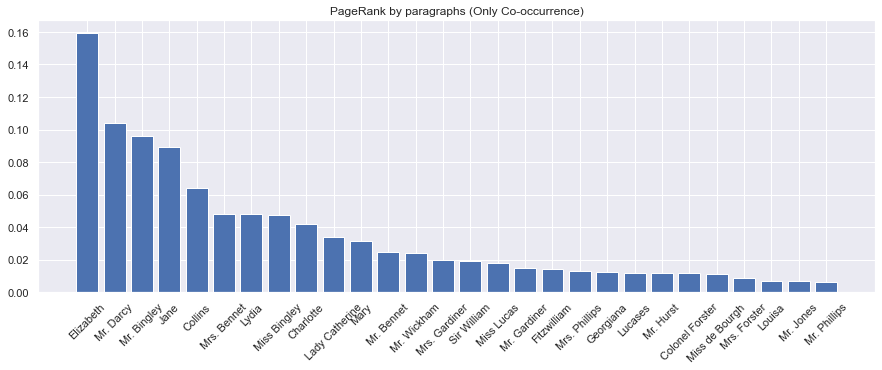

,Source,Target,Weight
0,Mr. Darcy,Mr. Darcy,0.00535714
1,Mr. Darcy,Mr. Bingley,0.151966
2,Mr. Darcy,Elizabeth,0.141632
3,Mr. Darcy,Miss Bingley,0.13849
4,Mr. Darcy,Lydia,0.08125
...,...,...,...
779,Mr. Jones,Mrs. Phillips,0.0303571
780,Mr. Jones,Fitzwilliam,0.00535714
781,Mr. Jones,Colonel Forster,0.00535714
782,Mr. Jones,Mrs. Forster,0.00535714


In [264]:
occur_paragraph, co_occur_paragraph= text_rank('paragraphs', cleaned_paragraph)
#co_occur_paragraph = pd.DataFrame(np.dot(occur_paragraph, occur_paragraph.T))
co_occur_paragraph.index = CHARACTER_LIST
co_occur_paragraph.columns = CHARACTER_LIST
relationship_paragraph = []
source = []
target = []

# Bingley视角出发对Darcy的weight 
for name_1 in CHARACTER_LIST:
    for name_2 in CHARACTER_LIST:
        #if name_1 != name_2: 
        source.append(name_1)
        target.append(name_2)
        relationship_paragraph.append(co_occur_paragraph.loc[name_1,name_2])
            
edge_paragraph = pd.DataFrame([source,target,relationship_paragraph]).T
edge_paragraph.columns = ['Source', 'Target', 'Weight']
edge_paragraph.to_csv('edge_paragraph.csv', index = False)

occur_paragraph.index = CHARACTER_LIST
times_paragraph = occur_paragraph.sum(axis = 1)
node_paragraph = pd.DataFrame([times_paragraph.index,times_paragraph.index,times_paragraph]).T
node_paragraph.columns = ['Id','Label','Weight']
node_paragraph.to_csv('node_paragraph.csv', index = False)
edge_paragraph

           TextRank  Occurrence Rank
1         Elizabeth        Elizabeth
2       Mr. Bingley        Mr. Darcy
3         Mr. Darcy      Mr. Bingley
4              Jane             Jane
5           Collins          Collins
6      Miss Bingley            Lydia
7             Lydia      Mrs. Bennet
8         Charlotte   Lady Catherine
9       Mrs. Bennet        Charlotte
10   Lady Catherine     Miss Bingley
11             Mary             Mary
12       Miss Lucas       Mr. Bennet
13      Mr. Wickham      Mr. Wickham
14       Mr. Bennet      Sir William
15      Sir William    Mrs. Gardiner
16    Mrs. Gardiner      Fitzwilliam
17      Fitzwilliam     Mr. Gardiner
18   Miss de Bourgh  Colonel Forster
19        Georgiana       Miss Lucas
20     Mr. Gardiner   Miss de Bourgh
21    Mrs. Phillips    Mrs. Phillips
22          Lucases        Georgiana
23        Mr. Hurst          Lucases
24  Colonel Forster        Mr. Hurst
25     Mrs. Forster     Mrs. Forster
26           Louisa           Louisa
2

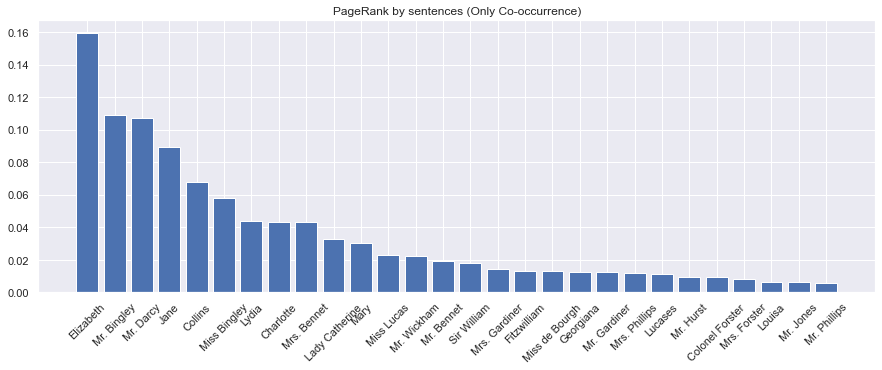

,Source,Target,Weight
0,Mr. Darcy,Mr. Darcy,0.00535714
1,Mr. Darcy,Mr. Bingley,0.131803
2,Mr. Darcy,Elizabeth,0.14103
3,Mr. Darcy,Miss Bingley,0.1368
4,Mr. Darcy,Lydia,0.0650063
...,...,...,...
779,Mr. Jones,Mrs. Phillips,0.00535714
780,Mr. Jones,Fitzwilliam,0.00535714
781,Mr. Jones,Colonel Forster,0.00535714
782,Mr. Jones,Mrs. Forster,0.00535714


In [265]:
occur_sentence, co_occur_sentence = text_rank('sentences', cleaned_sentence)
#co_occur_sentence = pd.DataFrame(np.dot(occur_sentence , occur_sentence.T))
co_occur_sentence.index = CHARACTER_LIST
co_occur_sentence.columns = CHARACTER_LIST
relationship_sentence = []
source = []
target = []

# Bingley视角出发对Darcy的weight 
for name_1 in CHARACTER_LIST:
    for name_2 in CHARACTER_LIST:
        #if name_1 != name_2: 
        source.append(name_1)
        target.append(name_2)
        relationship_sentence.append(co_occur_sentence.loc[name_1,name_2])

edge_sentence = pd.DataFrame([source,target,relationship_sentence]).T
edge_sentence.columns = ['Source', 'Target', 'Weight']
edge_sentence.to_csv('edge_sentence.csv', index = False)

occur_sentence.index = CHARACTER_LIST
times_sentence = occur_sentence.sum(axis = 1)
node_sentence = pd.DataFrame([times_sentence.index,times_sentence.index,times_sentence]).T
node_sentence.columns = ['Id','Label','Weight']
node_sentence.to_csv('node_sentence.csv', index = False)

edge_sentence

In [261]:
edge_sentence.drop(edge_sentence[edge_sentence.Weight == 0].index).to_csv('edge_sentence.csv', index = False)

## Sentiment Analysis
http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

In [17]:
#!pip3 install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm_notebook as tqdm

In [18]:
analyzer = SentimentIntensityAnalyzer()
chaper_wise_sentiment = []
for chapter in tqdm(cleaned_chapter):
    sentence_list = nltk.tokenize.sent_tokenize(chapter)
    sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        sentiments['compound'] += vs['compound']
        sentiments['neg'] += vs['neg']
        sentiments['neu'] += vs['neu']
        sentiments['pos'] += vs['pos']
    sentiments['compound'] = sentiments['compound'] / len(sentence_list)
    sentiments['neg'] = sentiments['neg'] / len(sentence_list)
    sentiments['neu'] = sentiments['neu'] / len(sentence_list)
    sentiments['pos'] = sentiments['pos'] / len(sentence_list)
    chaper_wise_sentiment.append(sentiments)

  0%|          | 0/61 [00:00<?, ?it/s]

In [19]:
SENTIMENTS = ['compound', 'neg', 'neu', 'pos']
y = [[sentiments['compound'] for sentiments in chaper_wise_sentiment],
     [sentiments['neg'] for sentiments in chaper_wise_sentiment],
     [sentiments['neu'] for sentiments in chaper_wise_sentiment],
     [sentiments['pos'] for sentiments in chaper_wise_sentiment]
    ]

In [20]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

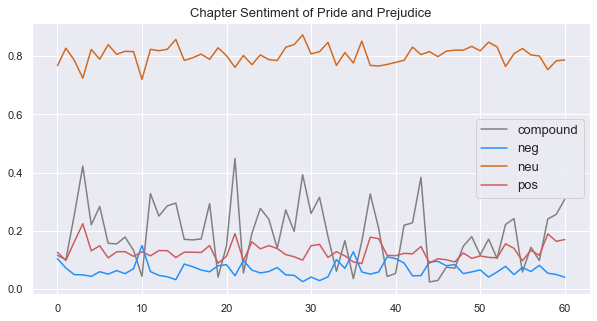

In [147]:
colors = ('grey', 'dodgerblue', 'chocolate', 'indianred')
plt.figure(figsize=(10,5))
for i in range(len(SENTIMENTS)):
    plt.plot(y[i],label=SENTIMENTS[i], color= colors[i])
    plt.legend(loc='best', fontsize=13)
plt.title('Chapter Sentiment of Pride and Prejudice', fontsize=13)
plt.show()

In [94]:
pd.DataFrame(y).T

,0,1,2,3
0,0.116777,0.105607,0.767339,0.127018
1,0.102081,0.073283,0.827528,0.099189
2,0.256128,0.050602,0.785639,0.163747
3,0.422894,0.050000,0.724680,0.225280
4,0.221578,0.044510,0.823286,0.132245
...,...,...,...,...
56,0.144436,0.061208,0.804319,0.134486
57,0.099210,0.082500,0.800758,0.116727
58,0.241666,0.055680,0.753849,0.190459
59,0.257289,0.050977,0.784170,0.164875


In [114]:
#sentiment_data = pd.DataFrame(y).T
#sentiment_data.columns = ['compound','negative','neutral','positive']
#sentiment_data
sentiment_data = pd.DataFrame(np.array(y).flatten(), columns = ['score'])
sentiment_data['element'] = ['compound']*len(y[0])+['negative']*len(y[0])+['neutral']*len(y[0])+['positive']*len(y[0])
sentiment_data['chapter'] = list(np.arange(1,len(y[0])+1)) * len(y)
sentiment_data

,score,element,chapter
0,0.116777,compound,1
1,0.102081,compound,2
2,0.256128,compound,3
3,0.422894,compound,4
4,0.221578,compound,5
...,...,...,...
239,0.134486,positive,57
240,0.116727,positive,58
241,0.190459,positive,59
242,0.164875,positive,60


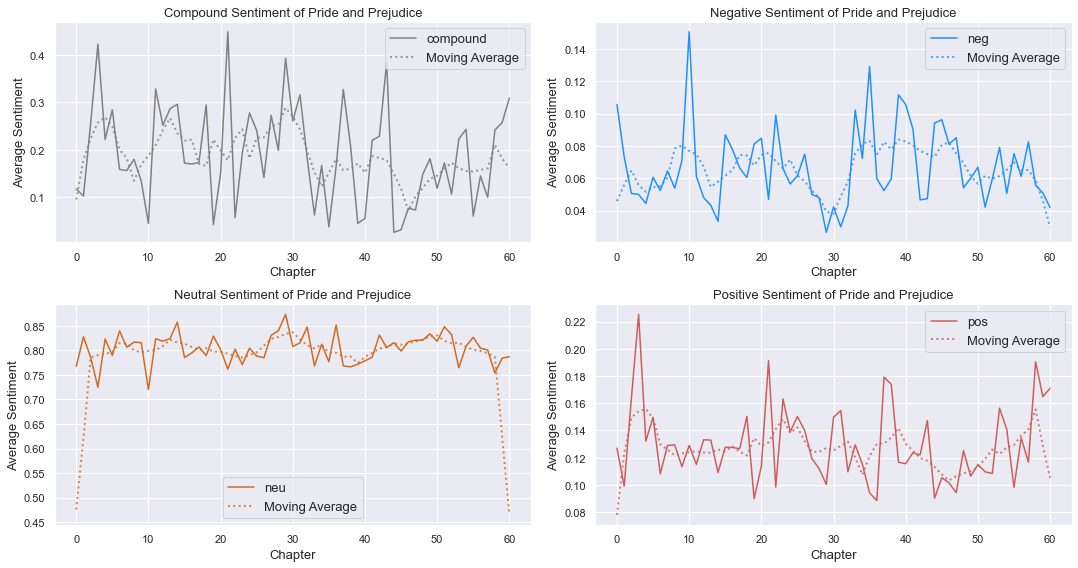

In [150]:
colors = ('grey', 'dodgerblue', 'chocolate', 'indianred')

plt.figure(figsize=(15,8))
plt.subplot(221)
plt.plot(y[0],label=SENTIMENTS[0], color= colors[0])
plt.plot(movingaverage(y[0], 5), color= colors[0], alpha = 0.8,linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=13)
plt.title('Compound Sentiment of Pride and Prejudice', fontsize=13)
plt.xlabel('Chapter', fontsize=13)
plt.ylabel('Average Sentiment', fontsize=13)

plt.subplot(222)
plt.plot(y[1],label=SENTIMENTS[1], color= colors[1])
plt.plot(movingaverage(y[1], 5), color= colors[1], alpha = 0.8, linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=13)
plt.title('Negative Sentiment of Pride and Prejudice', fontsize=13)
plt.xlabel('Chapter', fontsize=13)
plt.ylabel('Average Sentiment', fontsize=13)

plt.subplot(223)
plt.plot(y[2],label=SENTIMENTS[2], color= colors[2])
plt.plot(movingaverage(y[2], 5),  color= colors[2], alpha = 0.8,linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=13)
plt.title('Neutral Sentiment of Pride and Prejudice', fontsize=13)
plt.xlabel('Chapter', fontsize=13)
plt.ylabel('Average Sentiment', fontsize=13)

plt.subplot(224)
plt.plot(y[3],label=SENTIMENTS[3], color= colors[3])
plt.plot(movingaverage(y[3], 5), color= colors[3], alpha = 0.8,linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=13)
plt.title('Positive Sentiment of Pride and Prejudice', fontsize=13)
plt.xlabel('Chapter', fontsize=13)
plt.ylabel('Average Sentiment', fontsize=13)

plt.tight_layout()
plt.show()

---

In [26]:
analyzer_2 = SentimentIntensityAnalyzer()
sentiments_2 = {'compound': [], 'neg': [], 'neu': [], 'pos': []}
for chapter in tqdm(cleaned_chapter):
    sentence_list = nltk.tokenize.sent_tokenize(chapter)
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        sentiments_2['compound'].append(vs['compound'])
        sentiments_2['neg'].append(vs['neg'])
        sentiments_2['neu'].append(vs['neu'])
        sentiments_2['pos'].append(vs['pos'])

  0%|          | 0/61 [00:00<?, ?it/s]

(28, 28)
           TextRank  Occurrence Rank
1         Elizabeth        Elizabeth
2         Mr. Darcy             Jane
3              Jane        Mr. Darcy
4       Mr. Bingley      Mr. Bingley
5           Collins      Mrs. Bennet
6       Mrs. Bennet          Collins
7              Mary             Mary
8             Lydia            Lydia
9      Miss Bingley        Charlotte
10        Charlotte     Miss Bingley
11   Lady Catherine   Lady Catherine
12       Mr. Bennet       Mr. Bennet
13      Sir William      Mr. Wickham
14      Mr. Wickham      Sir William
15       Miss Lucas    Mrs. Gardiner
16    Mrs. Gardiner   Miss de Bourgh
17          Lucases     Mr. Gardiner
18   Miss de Bourgh          Lucases
19     Mr. Gardiner       Miss Lucas
20    Mrs. Phillips  Colonel Forster
21  Colonel Forster      Fitzwilliam
22      Fitzwilliam        Georgiana
23        Georgiana    Mrs. Phillips
24        Mr. Hurst        Mr. Hurst
25        Mr. Jones           Louisa
26     Mrs. Forster     Mrs. 

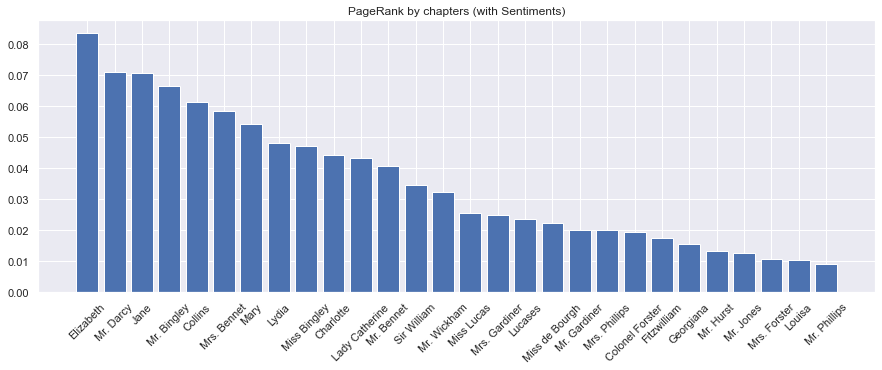

In [223]:
occurrence, co_occur = text_rank('chapters', cleaned_chapter, True)

(28, 28)
           TextRank  Occurrence Rank
1         Elizabeth        Elizabeth
2         Mr. Darcy        Mr. Darcy
3           Collins      Mr. Bingley
4              Jane             Jane
5       Mr. Bingley          Collins
6         Charlotte            Lydia
7    Lady Catherine      Mrs. Bennet
8       Mrs. Bennet   Lady Catherine
9             Lydia     Miss Bingley
10             Mary        Charlotte
11     Miss Bingley       Mr. Bennet
12      Sir William             Mary
13       Mr. Bennet      Mr. Wickham
14      Mr. Wickham    Mrs. Gardiner
15    Mrs. Gardiner      Sir William
16       Miss Lucas      Fitzwilliam
17      Fitzwilliam     Mr. Gardiner
18   Miss de Bourgh       Miss Lucas
19    Mrs. Phillips  Colonel Forster
20          Lucases   Miss de Bourgh
21     Mr. Gardiner    Mrs. Phillips
22  Colonel Forster          Lucases
23        Mr. Hurst        Georgiana
24        Mr. Jones        Mr. Hurst
25        Georgiana     Mrs. Forster
26     Mrs. Forster          

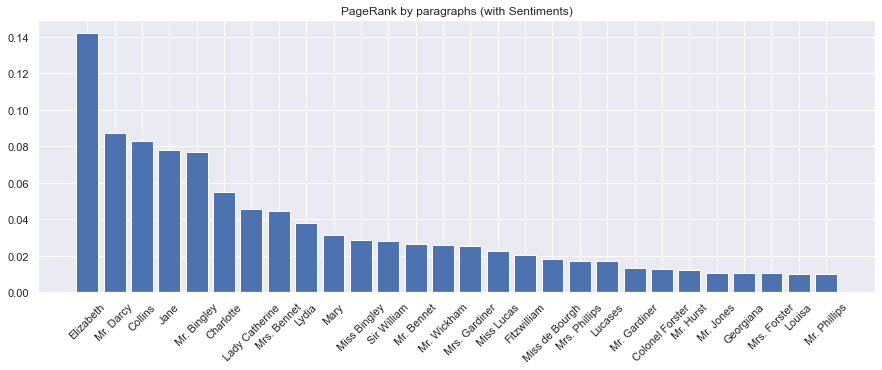

In [222]:
occurrence, co_occur = text_rank('paragraphs', cleaned_paragraph, True)

(28, 28)
           TextRank  Occurrence Rank
1         Elizabeth        Elizabeth
2         Mr. Darcy        Mr. Darcy
3           Collins      Mr. Bingley
4              Jane             Jane
5       Mr. Bingley          Collins
6         Charlotte            Lydia
7    Lady Catherine      Mrs. Bennet
8             Lydia   Lady Catherine
9      Miss Bingley        Charlotte
10      Mrs. Bennet     Miss Bingley
11       Miss Lucas             Mary
12             Mary       Mr. Bennet
13      Sir William      Mr. Wickham
14       Mr. Bennet      Sir William
15   Miss de Bourgh    Mrs. Gardiner
16      Mr. Wickham      Fitzwilliam
17      Fitzwilliam     Mr. Gardiner
18     Mr. Gardiner  Colonel Forster
19        Georgiana       Miss Lucas
20    Mrs. Phillips   Miss de Bourgh
21          Lucases    Mrs. Phillips
22    Mrs. Gardiner        Georgiana
23     Mrs. Forster          Lucases
24           Louisa        Mr. Hurst
25  Colonel Forster     Mrs. Forster
26        Mr. Jones          

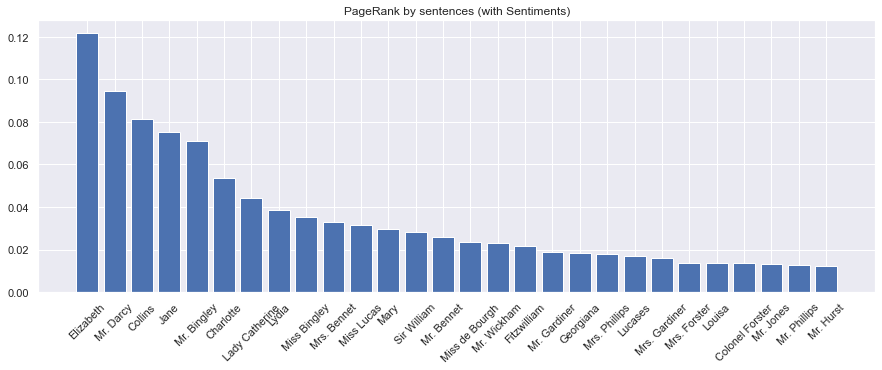

,Source,Target,Weight
0,Mr. Darcy,Mr. Darcy,0.0162037
1,Mr. Darcy,Mr. Bingley,0.143107
2,Mr. Darcy,Elizabeth,0.11403
3,Mr. Darcy,Miss Bingley,0.0794893
4,Mr. Darcy,Lydia,0.0621407
...,...,...,...
779,Mr. Jones,Mrs. Phillips,0.0261064
780,Mr. Jones,Fitzwilliam,0.0109745
781,Mr. Jones,Colonel Forster,0.0344359
782,Mr. Jones,Mrs. Forster,0.00535714


In [266]:
occurrence, co_occur = text_rank('sentences', cleaned_sentence, True)

co_occur.index = CHARACTER_LIST
co_occur.columns = CHARACTER_LIST
relationship_sentence = []
source = []
target = []

# Bingley视角出发对Darcy的weight 
for name_1 in CHARACTER_LIST:
    for name_2 in CHARACTER_LIST:
        #if name_1 != name_2: 
        source.append(name_1)
        target.append(name_2)
        relationship_sentence.append(co_occur.loc[name_1,name_2])

edge_sentence = pd.DataFrame([source,target,relationship_sentence]).T
edge_sentence.columns = ['Source', 'Target', 'Weight']
edge_sentence.to_csv('edge_sentence_s.csv', index = False)

occurrence.index = CHARACTER_LIST
times_sentence = occurrence.sum(axis = 1)
node_sentence = pd.DataFrame([times_sentence.index,times_sentence.index,times_sentence]).T
node_sentence.columns = ['Id','Label','Weight']
node_sentence.to_csv('node_sentence_s.csv', index = False)

edge_sentence

----


## Named entity recognition (NER)
is probably the first step towards information extraction that seeks to locate and classify named entities in text into pre-defined categories such as the names of persons,

In [ ]:
from __future__ import print_function
import nltk
print(nltk.__version__)

## Gephi 可视化


In [ ]:
import networkx as nx
G = nx.Graph() # 创建空图

G.add_node(1, time='5pm') # 添加节点，并赋节点属性
G.add_edge(1, 2, weight=4.7 ) # 添加边，并赋边属性

# 图显示需要借助matplotlib
import matplotlib.pyplot as plt

nx.draw(G) #绘制网络G
plt.show() # 在窗口中显示这幅图像
nx.write_gexf(G,'your_file_name.gexf') # 将图存为gexf文件，进而使用Gephi可视化


G._node # 节点及其属性的字典
G._adj # 节点及其邻居节点的字典
list(G.nodes()) # 节点列表

# 查找某一节点的邻居节点

In [53]:
def matrix_to_edge_list(matrix, mode, name_list):
    '''
    Function to convert matrix (co-occurrence/sentiment) to edge list of the network graph. It determines the
    weight and color of the edges in the network graph.
    :param matrix: co-occurrence matrix or sentiment matrix.
    :param mode: 'co-occurrence' or 'sentiment'
    :param name_list: the list of names of the top characters in the novel.
    :return: the edge list with weight and color param.
    '''
    edge_list = []
    shape = matrix.shape[0]
    lower_tri_loc = list(zip(*np.where(np.triu(np.ones([shape, shape])) == 0)))
    normalized_matrix = matrix / np.max(np.abs(matrix))
    if mode == 'co-occurrence':
        weight = np.log(2000 * normalized_matrix + 1) * 0.7
        color = np.log(2000 * normalized_matrix + 1)
    if mode == 'sentiment':
        weight = np.log(np.abs(1000 * normalized_matrix) + 1) * 0.7
        color = 2000 * normalized_matrix
    for i in lower_tri_loc:
        edge_list.append((name_list[i[0]], name_list[i[1]], {'weight': weight[i], 'color': color[i]}))

    return edge_list

In [54]:
def plot_graph(name_list, name_frequency, matrix, plt_name, mode, path=''):
    '''
    Function to plot the network graph (co-occurrence network or sentiment network).
    :param name_list: the list of top character names in the novel.
    :param name_frequency: the list containing the frequencies of the top names.
    :param matrix: co-occurrence matrix or sentiment matrix.
    :param plt_name: the name of the plot (PNG file) to output.
    :param mode: 'co-occurrence' or 'sentiment'
    :param path: the path to output the PNG file.
    :return: a PNG file of the network graph.
    '''

    label = {i: i for i in name_list}
    edge_list = matrix_to_edge_list(matrix, mode, name_list)
    normalized_frequency = np.array(name_frequency) / np.max(name_frequency)

    plt.figure(figsize=(20, 20))
    G = nx.Graph()
    G.add_nodes_from(name_list)
    G.add_edges_from(edge_list)
    pos = nx.circular_layout(G)
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    colors = [G[u][v]['color'] for u, v in edges]

    if mode == 'co-occurrence':
        nx.draw(G, pos, node_color='#A0CBE2', node_size=np.sqrt(normalized_frequency) * 4000, edge_cmap=plt.cm.Blues,
                linewidths=10, font_size=35, labels=label, edge_color=colors, with_labels=True, width=weights)
    elif mode == 'sentiment':
        nx.draw(G, pos, node_color='#A0CBE2', node_size=np.sqrt(normalized_frequency) * 4000,
                linewidths=10, font_size=35, labels=label, edge_color=colors, with_labels=True,
                width=weights, edge_vmin=-1000, edge_vmax=1000)
    else:
        raise ValueError("mode should be either 'co-occurrence' or 'sentiment'")

    plt.savefig(path + plt_name + '.png')

In [55]:
name_frequency = list(occurrence.sum(axis = 1))
novel_name = 'Pride and Prejudice'


In [56]:
plot_graph(CHARACTER_LIST, name_frequency, co_occur, novel_name + ' co-occurrence graph', 'co-occurrence')

KeyError: (1, 0)